In [ ]:
!pip install simpletransformers
!pip install contractions

     |████████████████████████████████| 204kB 15.1MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 317kB 50.8MB/s 
     |████████████████████████████████| 2.9MB 57.2MB/s 
     |████████████████████████████████| 1.8MB 51.2MB/s 
     |████████████████████████████████| 7.5MB 57.6MB/s 
     |████████████████████████████████| 1.5MB 60.4MB/s 
     |████████████████████████████████| 71kB 12.4MB/s 
     |████████████████████████████████| 1.1MB 46.6MB/s 
     |████████████████████████████████| 102kB 16.5MB/s 
     |████████████████████████████████| 133kB 61.0MB/s 
     |████████████████████████████████| 163kB 65.8MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
     |████████████████████████████████| 4.5MB 59.3MB/s 
     |████████████████████████████████| 112kB 64.3MB/s 
     |████████████████████████████████| 890kB 43.6MB/s 
     |████████████████████████████████| 71kB 12.1MB/s 
     |████████████████████████████████| 122kB 58.7MB/

     |████████████████████████████████| 245kB 20.3MB/s 
     |████████████████████████████████| 317kB 44.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81704 sha256=fb81b6fe09979a3032763dd93a434c9fcd47bc4522d975c16fc31b5955208f77
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
import pandas as pd
import numpy as np
import random 
import os
import re
import pandas as pd
import numpy as np
import contractions
from bs4 import BeautifulSoup
from html import unescape
import torch
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import *
from sklearn.model_selection import *
from scipy.special import softmax
import matplotlib.pyplot as plt

In [ ]:
#Text Preprocessing Libraries
import re
import nltk
import string
nltk.download('punkt', 'stopwords')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english")) 


[nltk_data] Downloading package punkt to stopwords...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Loading Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/kaggle-nabil-badri/dataset-hatespeech+rumor/hatespeech_text_label_vote - hatespeech_text_label_vote.csv")

In [ ]:
df.drop('Unnamed: 2',axis = 1, inplace=True)

In [ ]:
df.head()

,text,label
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,spam
1,RT @Papapishu: Man it would fucking rule if we...,abusive
2,It is time to draw close to Him &#128591;&#127...,normal
3,if you notice me start to act different or dis...,normal
4,"Forget unfollowers, I believe in growing. 7 ne...",normal


In [ ]:
df.label.value_counts()

normal     53851
abusive    27150
spam       14030
hateful     4965
Name: label, dtype: int64

In [ ]:
#Encoding
df.label.replace({'normal':0,'abusive':1,'spam':2,'hateful':3},inplace=True)
df.head()

,text,label
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,2
1,RT @Papapishu: Man it would fucking rule if we...,1
2,It is time to draw close to Him &#128591;&#127...,0
3,if you notice me start to act different or dis...,0
4,"Forget unfollowers, I believe in growing. 7 ne...",0


### Setting up RoBERTa

In [ ]:
def random_seed(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
seed=7
random_seed(seed)

In [ ]:
def get_model(model_type, model_name, n_epochs = 2, seq_len = 300, lr = 2e-5,):
  model = ClassificationModel(model_type, model_name,num_labels=4, args={
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': n_epochs,
                                                                         'max_seq_length': seq_len,
                                                                         "learning_rate":lr,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False
                                                                         })
  return model

Cleaning Text

In [ ]:
lemmatizer = WordNetLemmatizer()
corpus_train = []
for i in df['text']:
    x=i.lower()
    x=x.replace('@user','')
    x=x.replace('@[\w\-]+','')
    x=x.translate(str.maketrans('', '', string.punctuation))
    x = re.sub('[^A-Za-z]', ' ', x)
    x=re.sub('\s+',' ',x)
    x=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',x) #url
    x = [lemmatizer.lemmatize(token) for token in x.split(" ")]
    x = [word for word in x if not word in stop_words]
    x=" ".join(x)
    corpus_train.append(x) 

In [ ]:
df['text'] = corpus_train

### Splitting Data

In [ ]:
#Shuffle the data
df = df.sample(frac=1)

In [ ]:
#Splitting the data 80% train, 20%
split = round(len(df) * 0.8)
Train = df[:split]
Test = df[split:]

Training Model

In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
model = get_model('roberta', 'roberta-base', n_epochs=1,lr=2e-5)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
model.train_model(Train)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:391: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/79997 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(10000, 0.5571492167746648)

Generating Predictions

In [ ]:
Predictions = model.eval_model(Test)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:970: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/19999 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/2500 [00:00<?, ?it/s]

Metrics


In [ ]:
y_test = Test.label

In [ ]:
raw_outputs_vals = softmax(Predictions[1],axis=1)
raw_outputs_vals.argmax(axis=1)
print(classification_report(y_test,raw_outputs_vals.argmax(axis=1), target_names=(['normal','abusive','spam','hateful'])))

              precision    recall  f1-score   support

      normal       0.85      0.87      0.86     10800
     abusive       0.85      0.93      0.89      5413
        spam       0.61      0.53      0.57      2855
     hateful       0.59      0.32      0.42       931

    accuracy                           0.81     19999
   macro avg       0.73      0.66      0.68     19999
weighted avg       0.80      0.81      0.81     19999



In [ ]:
metric =(accuracy_score(y_test,raw_outputs_vals.argmax(axis=1)), 
        f1_score(y_test,raw_outputs_vals.argmax(axis=1), average='macro'),
        recall_score(y_test,raw_outputs_vals.argmax(axis=1), average='macro'),
        precision_score(y_test,raw_outputs_vals.argmax(axis=1), average='macro'))

(0.0, 1.0)

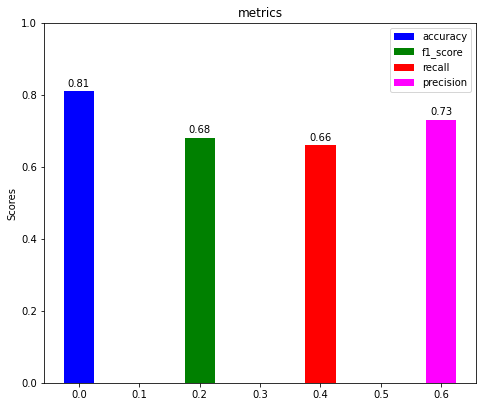

In [ ]:
fig = plt.figure()
fig.set_size_inches(6,5)
ax = fig.add_axes([0,0,1,1])
rect1 = ax.bar(0.00,round(metric[0], 2), color = 'b', width = 0.05)
rect2 = ax.bar(0.20, round(metric[1], 2), color = 'g', width = 0.05)
rect3 = ax.bar(0.40, round(metric[2], 2) , color = 'r', width = 0.05)
rect4 = ax.bar(0.60, round(metric[3], 2) , color = (1, 0, 1), width = 0.05)

ax.set_ylabel('Scores')
ax.set_title('metrics')
def autolabel(rects):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
      height = rect.get_height()
      ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
autolabel(rect4)
ax.legend(labels=['accuracy', 'f1_score', 'recall', 'precision'],loc='best')
plt.ylim(0, 1)

In [ ]:
: